# Dataset Creation

In [1]:
# 1) Creating the dataset using API calls to the Jira platform for the HADOOP projects
# Importing required libraries

In [2]:
!pip install jira
from jira import JIRA
import pprint
import pandas as pd

In [3]:
# Intializing server connections to the Jira platform
# Writing the accquired data to a dataframe with required columns to classify the type of issues
options = {"server": "https://issues.apache.org/jira",'verify':False}
conn = JIRA(options)
project_str = 'project="HADOOP"'
issues = conn.search_issues(project_str,startAt=0,maxResults=1000)
# define dataframe to store data
df = pd.DataFrame(columns=["title", "description", "priority"])
for index, issue in enumerate(issues):
  issue_dict = issue.raw["fields"]
  df.loc[index] = [issue_dict['summary'],issue_dict['description'],issue_dict['priority']['name']]

c:\users\siva\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1050: InsecureRequestWarning: Unverified HTTPS request is being made to host 'issues.apache.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\siva\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1050: InsecureRequestWarning: Unverified HTTPS request is being made to host 'issues.apache.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\siva\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1050: InsecureRequestWarning: Unverified HTTPS request is being made to host 'issues.apache.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/

In [4]:
# Cleaning up the dataset and creating necessary labels
df['features'] = df['title'] + " " + df['description']
df1 = df.copy()
df1.features = df1.features.str.replace(r"[\n\r\t]+", " ")
df1.features = df1.features.str.replace(r"([a-zA-Z0-9_\-\.]+)@([a-zA-Z0-9_\-\.]+)\.([a-zA-Z]{2,5})", " ")
df1.features = df1.features.str.replace(r"((http[s]?|ftp):\/)?\/?([^:\/\s]+)((\/\w+)*\/)([\w\-\.]+[^#?\s]+)(.*)?(#[\w\-]+)?", " ")
df1.features = df1.features.str.replace(r"([0-9]+)", " ")
df1['b_labels'] = df1['priority'].map({'Trivial': 0, 'Minor': 1, 'Major': 2, 'Blocker': 3, 'Critical': 4})
Y = df1['b_labels'].values


c:\users\siva\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
c:\users\siva\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
c:\users\siva\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
c:\users\siva\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


In [5]:
# Saving the dataframe as a csv file
df1.to_csv('JIRA_HADOOP.csv')

# Building the Pytorch Model

In [6]:
# Importing necessary libraries for the creation of the Pytorch Model
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error

In [7]:
# Loading the data from the csv file and previewing
data = pd.read_csv("JIRA_HADOOP.csv")
print(data.shape)
data.head()

(1000, 6)


,Unnamed: 0,title,description,priority,features,b_labels
0,0,upgrade jackson-databind to 2.13.2.1 due to cve,https://github.com/FasterXML/jackson-databind/...,Major,upgrade jackson-databind to . . . due to cve,2
1,1,document use and design of prefetching s3a inp...,Document S3PrefetchingInputStream for users (...,Major,document use and design of prefetching s a inp...,2
2,2,s3a prefetching stream to move off twitter Fut...,This has to be a blocker for the merge I'm afr...,Major,s a prefetching stream to move off twitter Fut...,2
3,3,test failures with prefetching s3a input stream,identify and fix all test regressions from the...,Major,test failures with prefetching s a input strea...,2
4,4,IBM Java detected while running on OpenJDK cla...,In our project we are using hadoop-client libr...,Major,IBM Java detected while running on OpenJDK cla...,2


In [8]:
data['title'] = data['title'].fillna('')
data['description'] = data['description'].fillna('')
data['feature'] = data['title'] + ' ' + data['description']

In [9]:
# Retaining relevant columns and Calculating sentence lengths
data = data[['feature', 'b_labels']]
data.columns = ['feature', 'b_labels']
data['feature_length'] = data['feature'].apply(lambda x: len(x.split()))
data.head()

,feature,b_labels,feature_length
0,upgrade jackson-databind to 2.13.2.1 due to cv...,2,8
1,document use and design of prefetching s3a inp...,2,31
2,s3a prefetching stream to move off twitter Fut...,2,86
3,test failures with prefetching s3a input strea...,2,19
4,IBM Java detected while running on OpenJDK cla...,2,389


In [10]:
# Calculating the mean of the sentence length
np.mean(data['feature_length'])

82.807

In [11]:
# Checking the counts
data['b_labels'].value_counts()

2    705
1    207
4     31
3     31
0     26
Name: b_labels, dtype: int64

In [12]:
# Tokenizing the sentences for further manipulation
to = spacy.load('en_core_web_sm')
def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in to.tokenizer(nopunct)]

In [13]:
# Taking the count number of occurences of each word
counts = Counter()
for index, row in data.iterrows():
    counts.update(tokenize(row['feature']))

In [14]:
# Removing infrequent words in the data
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 8319
num_words after: 5154


In [15]:
# Generation of the vocabulary base
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [16]:
# Creation of the encoding function
def encode_sentence(text, vocab2index, N=70):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [17]:
data['encoded'] = data['feature'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
data.head()

c:\users\siva\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


,feature,b_labels,feature_length,encoded
0,upgrade jackson-databind to 2.13.2.1 due to cv...,2,8,"[[2, 3, 4, 5, 6, 7, 5, 8, 9, 10, 11, 12, 13, 3..."
1,document use and design of prefetching s3a inp...,2,31,"[[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 16, ..."
2,s3a prefetching stream to move off twitter Fut...,2,86,"[[22, 23, 21, 25, 5, 56, 57, 58, 1, 59, 60, 5,..."
3,test failures with prefetching s3a input strea...,2,19,"[[108, 109, 110, 21, 22, 23, 24, 25, 111, 18, ..."
4,IBM Java detected while running on OpenJDK cla...,2,389,"[[115, 48, 116, 117, 118, 119, 120, 121, 99, 3..."


In [18]:
# Checking the balance of the dataset
Counter(data['b_labels'])

Counter({2: 705, 1: 207, 4: 31, 0: 26, 3: 31})

In [19]:
X = list(data['encoded'])
y = list(data['b_labels'])
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [20]:
# Creation of the HADOOP Dataset
class HADOOPDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [21]:
# Training and Validation variables
train_ds = HADOOPDataset(X_train, y_train)
valid_ds = HADOOPDataset(X_valid, y_valid)

In [22]:
# 2) Create a RNN model to classify an issue to a type

In [23]:
# Creating the Training function and Evaluation Function
def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long()
            y = y.long()
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)
        if i % 5 == 1:
            print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse))
            
def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

In [24]:
# Defining the batch size and vocab size
batch_size = 5000 
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

### Training LSTM RNN for variable length input

In [25]:
# Class definition for the LSTM RNN
class LSTM_variable_input(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(0.3)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        
    def forward(self, x, s):
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(x_pack)
        out = self.linear(ht[-1])
        return out

In [26]:
model = LSTM_variable_input(vocab_size, 50, 50)

In [27]:
train_model(model, epochs=30, lr=0.1)

train loss 1.130, val loss 1.400, val accuracy 0.725, and val rmse 0.707
train loss 0.653, val loss 1.170, val accuracy 0.660, and val rmse 0.778
train loss 0.409, val loss 1.646, val accuracy 0.610, and val rmse 0.815
train loss 0.296, val loss 1.857, val accuracy 0.620, and val rmse 0.828
train loss 0.191, val loss 2.159, val accuracy 0.580, and val rmse 0.880
train loss 0.121, val loss 2.435, val accuracy 0.570, and val rmse 0.886


In [28]:
train_model(model, epochs=30, lr=0.05)

train loss 0.080, val loss 2.749, val accuracy 0.570, and val rmse 0.837
train loss 0.067, val loss 3.207, val accuracy 0.565, and val rmse 0.854
train loss 0.052, val loss 3.548, val accuracy 0.600, and val rmse 0.854
train loss 0.047, val loss 3.583, val accuracy 0.570, and val rmse 0.903
train loss 0.045, val loss 3.728, val accuracy 0.585, and val rmse 0.869
train loss 0.029, val loss 3.942, val accuracy 0.580, and val rmse 0.854


In [29]:
train_model(model, epochs=30, lr=0.05)

train loss 0.027, val loss 4.135, val accuracy 0.635, and val rmse 0.803
train loss 0.023, val loss 4.162, val accuracy 0.590, and val rmse 0.837
train loss 0.026, val loss 4.341, val accuracy 0.610, and val rmse 0.843
train loss 0.012, val loss 4.359, val accuracy 0.615, and val rmse 0.815
train loss 0.017, val loss 4.486, val accuracy 0.580, and val rmse 0.914
train loss 0.012, val loss 4.731, val accuracy 0.570, and val rmse 0.941


### Evaluation of the LSTM RNN for variable length input

              precision    recall  f1-score   support

     Trivial       0.00      0.00      0.00         7
       Minor       0.20      0.14      0.17        35
       Major       0.73      0.77      0.74       145
     Blocker       0.00      0.00      0.00         5
    Critical       0.12      0.12      0.12         8

    accuracy                           0.58       200
   macro avg       0.21      0.21      0.21       200
weighted avg       0.57      0.58      0.57       200



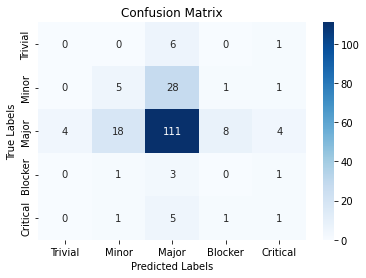

In [30]:
# Evaluation Function Definition
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
def evaluate(model, val_dl, version='title', threshold=0.5):
    y_pred = []
    y_true = []
    target_names = ['Trivial', 'Minor','Major', 'Blocker', 'Critical']
    model.eval()
    with torch.no_grad():
      for x, y, l in val_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        pred = torch.max(y_hat, 1)[1]
        # print("pred",pred)
        y_pred.extend(pred.tolist())
        y_true.extend(y.tolist())
    print(classification_report(y_true, y_pred, target_names=target_names))


    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Trivial', 'Minor','Major', 'Blocker', 'Critical'])
    ax.yaxis.set_ticklabels(['Trivial', 'Minor','Major', 'Blocker', 'Critical'])
    return y_pred,y_true
y_pred,y_true= evaluate(model, val_dl)

### Alternative: LSTM with pre-trained Glove word embeddings

In [31]:
# To download the Glove repo and it's corresponding data
import requests, zipfile, io
r = requests.get("https://nlp.stanford.edu/data/glove.6B.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("C:/Users/SIVA/Desktop/Practical_Project/Two_version")

In [32]:
# Defining the Glove function for word manipulations
def load_glove_vectors(glove_file="./glove.6B.50d.txt"):
    """Load the glove word vectors"""
    word_vectors = {}
    with open(glove_file, encoding="utf8") as f:
        for line in f:
            split = line.split()
            word_vectors[split[0]] = np.array([float(x) for x in split[1:]])
    return word_vectors

In [33]:
# Function definition to create an embedding matrix
def get_emb_matrix(pretrained, word_counts, emb_size = 50):
    """ Creates embedding matrix from word vectors"""
    vocab_size = len(word_counts) + 2
    vocab_to_idx = {}
    vocab = ["", "UNK"]
    W = np.zeros((vocab_size, emb_size), dtype="float32")
    W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 
    vocab_to_idx["UNK"] = 1
    i = 2
    for word in word_counts:
        if word in word_vecs:
            W[i] = word_vecs[word]
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
        vocab_to_idx[word] = i
        vocab.append(word)
        i += 1   
    return W, np.array(vocab), vocab_to_idx

In [34]:
word_vecs = load_glove_vectors()
pretrained_weights, vocab, vocab2index = get_emb_matrix(word_vecs, counts)

In [35]:
# LSTM with glove function definition
class LSTM_glove_vecs(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, glove_weights) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(glove_weights))
        self.embeddings.weight.requires_grad = False ## freeze embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [36]:
model = LSTM_glove_vecs(vocab_size, 50, 50, pretrained_weights)

In [37]:
train_model(model, epochs=30, lr=0.1)

train loss 1.492, val loss 1.814, val accuracy 0.175, and val rmse 1.105
train loss 0.923, val loss 0.890, val accuracy 0.725, and val rmse 0.707
train loss 0.875, val loss 0.892, val accuracy 0.725, and val rmse 0.707
train loss 0.862, val loss 0.902, val accuracy 0.725, and val rmse 0.707
train loss 0.854, val loss 0.904, val accuracy 0.725, and val rmse 0.707
train loss 0.833, val loss 0.902, val accuracy 0.725, and val rmse 0.707


In [38]:
train_model(model, epochs=30, lr=0.05)

train loss 0.881, val loss 0.904, val accuracy 0.725, and val rmse 0.707
train loss 0.787, val loss 0.942, val accuracy 0.720, and val rmse 0.711
train loss 0.755, val loss 0.949, val accuracy 0.690, and val rmse 0.731
train loss 0.724, val loss 0.968, val accuracy 0.720, and val rmse 0.700
train loss 0.690, val loss 0.995, val accuracy 0.710, and val rmse 0.707
train loss 0.664, val loss 1.055, val accuracy 0.695, and val rmse 0.728


In [39]:
train_model(model, epochs=30, lr=0.05)

train loss 0.768, val loss 1.112, val accuracy 0.690, and val rmse 0.731
train loss 0.612, val loss 1.102, val accuracy 0.675, and val rmse 0.778
train loss 0.585, val loss 1.151, val accuracy 0.700, and val rmse 0.762
train loss 0.581, val loss 1.164, val accuracy 0.695, and val rmse 0.784
train loss 0.546, val loss 1.192, val accuracy 0.685, and val rmse 0.781
train loss 0.537, val loss 1.228, val accuracy 0.705, and val rmse 0.748


### Evaluation of the LSTM with Glove Model

              precision    recall  f1-score   support

     Trivial       0.00      0.00      0.00         7
       Minor       0.12      0.03      0.05        35
       Major       0.73      0.94      0.82       145
     Blocker       0.00      0.00      0.00         5
    Critical       0.50      0.12      0.20         8

    accuracy                           0.69       200
   macro avg       0.27      0.22      0.21       200
weighted avg       0.57      0.69      0.61       200



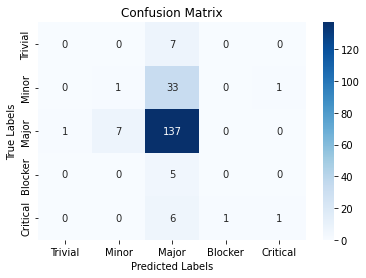

In [40]:
# Evaluation Function
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
def evaluate(model, val_dl, version='title', threshold=0.5):
    y_pred = []
    y_true = []
    target_names = ['Trivial', 'Minor','Major', 'Blocker', 'Critical']
    model.eval()
    with torch.no_grad():
      for x, y, l in val_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        pred = torch.max(y_hat, 1)[1]
        # print("pred",pred)
        y_pred.extend(pred.tolist())
        y_true.extend(y.tolist())
    print(classification_report(y_true, y_pred, target_names=target_names))


    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Trivial', 'Minor','Major', 'Blocker', 'Critical'])
    ax.yaxis.set_ticklabels(['Trivial', 'Minor','Major', 'Blocker', 'Critical'])
    return y_pred,y_true
y_pred,y_true= evaluate(model, val_dl)

The dataset used for this uses the key fields "description" and "summary" to predict the type of issue. The data which has been 
acquired through the HADOOP platform produces a dataset which has majorly the types as "Major" or "Minor" due which the training can be minorly biased towards only to these two types of issues. Two methods have been used for the purpose of training and evaluating.